#  &#x1F4D1; **HW4 音频分类**
- 给定音频区分出说话的人
- 主要目标: 学会使用transformer
- Baselines:
  - Easy: 知道怎么使用transformer, 输出简单的可以运行的脚本.
  - Medium: 知道transformer如何调参.
  - <font color=darkred><b>Strong: 改变transformer的结构，使用一种transformer变体—— [conformer](https://arxiv.org/abs/2005.08100)  </font></b>
  - <font color=darkred><b>Boss: 使用 [Self-Attention Pooling](https://arxiv.org/pdf/2008.01077v1.pdf) & [Additive Margin Softmax](https://arxiv.org/pdf/1801.05599.pdf)进一步提升模型表现. </font></b>


- 其他链接：
  - Kaggle: [link](https://www.kaggle.com/t/ac77388c90204a4c8daebeddd40ff916)
  - Slide: [link](https://docs.google.com/presentation/d/1HLAj7UUIjZOycDe7DaVLSwJfXVd3bXPOyzSb6Zk3hYU/edit?usp=sharing)
  - Data: [link](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

# **加载包**

In [14]:
!pip install torchviz

In [15]:
import pandas as pd 
import numpy as np
import random
from pathlib import Path

import torch
import torch.nn as nn 
from torch.utils.data import Dataset, random_split, DataLoader
from torch import functional  as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from torch.nn.utils.rnn import pad_sequence
import math

import os
import sys
import json
from tqdm import tqdm
# 绘制评估曲线
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from torchviz import make_dot

import warnings 
from rich.console import Console
warnings.filterwarnings('ignore')
cs = Console()

# **下载数据**
```python
!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partaa
!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partab
!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partac
!wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partad
!cat Dataset.tar.gz.part* > Dataset.tar.gz
# unzip the file
!tar zxvf Dataset.tar.gz
```
如果https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/ 下载不了可以用以下途径下载数据
- [Kaggle Data: ml2022spring-hw4](https://www.kaggle.com/competitions/ml2022spring-hw4/data)

# **一些重要的函数**
- all_seed 设置随机种子

In [16]:
def model_plot(model_class, input_sample):
    clf = model_class()
    y = clf(input_sample) 
    clf_view = make_dot(y, params=dict(list(clf.named_parameters()) + [('x', input_sample)]))
    return clf_view


def all_seed(seed=6666):
    np.random.seed(seed)
    random.seed(seed)
    # CPU
    torch.manual_seed(seed)
    # GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
    # python全局
    os.environ['PYTHONHASHSEED'] = str(seed)
    # cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    print(f'Set env random_seed = {seed}')

In [17]:
all_seed(87)

Set env random_seed = 87


# **数据集**
- 原始数据集 [Voxceleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb2.
- 我们从Voxceleb2数据集中随机抽取600个演讲者 
- 将数据原始波形转换为mel谱图

- 文件夹的结构如下:
  - data directory   
  |---- metadata.json    
  |---- testdata.json     
  |---- mapping.json     
  |---- uttr-{random string}.pt   

- metadata.json中的信息
  - "n_mels": 40， mel图谱的维度.
  - "speakers": 字典. 
    - Key: speaker ids.
    - value: "feature_path"-特征文件 and "mel_len"-特征的长度


为了更加高效, 我们在训练的时候将mel图谱分割成一定的长度。

In [18]:
# 查看数据
data_dir = '../input/ml2022spring-hw4/Dataset'

# mapping.json
map_ = Path(data_dir) / 'mapping.json'
map_js = json.load(map_.open())
cs.print('mapping.json | keys = ', map_js.keys())
# metadata.json 
matedata_ = Path(data_dir) / 'metadata.json'
matedata_js = json.load(matedata_.open())
cs.print('metadata.json | keys = ', matedata_js.keys())
cs.print("matedata_js['n_mels']=", matedata_js['n_mels'])
cs.print(
    "matedata_js['speakers']['id00559'][:5]=", 
    matedata_js['speakers']['id00559'][:5]
)

mel = torch.load(os.path.join(data_dir, 'uttr-2918eae600684146903d49f02275cb94.pt'))
cs.print(f'(mel_len, n_mels)={mel.shape}') 
mel

mapping.json | keys =  dict_keys(['speaker2id', 'id2speaker'])

metadata.json | keys =  dict_keys(['n_mels', 'speakers'])

matedata_js['n_mels']= 40

matedata_js['speakers']['id00559'][:5]=
[
    {'feature_path': 'uttr-2918eae600684146903d49f02275cb94.pt', 'mel_len': 397},
    {'feature_path': 'uttr-ba3892259e03442a8113180f0e4630c5.pt', 'mel_len': 603},
    {'feature_path': 'uttr-787eb20b357a4e2ebfb267611efbf92a.pt', 'mel_len': 584},
    {'feature_path': 'uttr-863c9d7ab6bd4a70938481549e426fdc.pt', 'mel_len': 457},
    {'feature_path': 'uttr-a9145f8b565f4d18894bce985b9ee3af.pt', 'mel_len': 648}
]

(mel_len, n_mels)=torch.Size([397, 40])

tensor([[  5.9532,   5.7866,   4.2582,  ...,  -7.4547,  -7.9219,  -2.2850],
        [  5.6307,   4.8402,   1.5912,  ...,  -6.9332,  -7.1366,  -4.4466],
        [  5.2866,   5.0213,   2.9144,  ...,  -7.2181,  -7.3338,  -4.4947],
        ...,
        [-17.3427, -17.0293, -16.7071,  ..., -18.6104, -18.7724, -18.9308],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233],
        [-20.7233, -20.7233, -20.7233,  ..., -20.7233, -20.7233, -20.7233]])

In [19]:
class myDataset(Dataset):
    def __init__(self, data_dir, segment_len=128):
        super(myDataset, self).__init__()
        self.data_dir = data_dir
        self.segment_len = segment_len
        # 加载演讲者和id编码的映射.
        mapping_path = Path(data_dir) / 'mapping.json'
        mapping = json.load(mapping_path.open())
        self.speaker2id = mapping['speaker2id']
        
        # 加载训练数据的源数据(特征文件， 演讲者)
        metadata_path = Path(data_dir) / 'metadata.json'
        metadata = json.load(metadata_path.open())['speakers']
        
        # 获取总演讲者数
        self.speaker_num = len(metadata.keys())
        self.data = []
        for speaker, utt in metadata.items():
            for utt_i in utt:
                self.data.append([utt_i['feature_path'], self.speaker2id[speaker]])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        feat_path, speaker = self.data[index]
        # 载入经过预处理的mel图谱特征(mel-spectrogram)
        mel = torch.load(os.path.join(self.data_dir, feat_path))
        # 分割 mel-specrogram
        if len(mel) > self.segment_len:
            # 开始的位置为随机
            start = random.randint(0, len(mel) - self.segment_len)
            # 切分语音
            mel = torch.FloatTensor(mel[start: start + self.segment_len])
        else:
            mel = torch.FloatTensor(mel)
        # 将speaker 转成long格式便于后续计算loss
        speaker = torch.FloatTensor([speaker]).long()
        return mel, speaker
    
    def get_speaker_number(self):
        return self.speaker_num


class InferenceDataset(Dataset):
    def __init__(self, data_dir):
        super(InferenceDataset, self).__init__()
        test_path = Path(data_dir) / 'testdata.json'
        metadata = json.load(test_path.open())
        self.data_dir = data_dir 
        self.data = metadata['utterances'] 
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        utt = self.data[index]
        feat_path = utt['feature_path']
        mel = torch.load(os.path.join(self.data_dir, feat_path))
        return feat_path, mel
    
    
def inference_collate_batch(batch):
    feat_path, mels = zip(*batch)
    return feat_path, torch.stack(mels)

##  &#x2728;  **Transformer模型**
<font color=darkred><b>***TODO***: encode改用Conformer</font></b>  
<font color=darkred><b>***TODO***: 增加Self-Attention Pooling Layer</font></b>  

- 可以参考[https://github.com/sooftware/conformer](https://github.com/sooftware/conformerhttps://github.com/sooftware/conformer)
- self-attetion & multi-self-attention & transformer block可以看李老师的视频
    - [B站视频 第五讲 Transformer-2](https://www.bilibili.com/video/BV1m3411p7wD?p=33&vd_source=f209dda877a0d7be7d5309f93b340d6f)

In [20]:
class Classifier(nn.Module):
    def __init__(self, input_dim=40, d_model=80, n_spks=600, dropout=0.1):
        super(Classifier, self).__init__()
        self.pre_net = nn.Linear(input_dim, d_model)
        # TODO:
        #   尝试改变Transformer， 改成Conformer.
        #   https://arxiv.org/abs/2005.08100 
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,  # self_attn [Q, K, V] shape=(d_model*3, d_model)
            dim_feedforward=256,
            nhead=2, 
            batch_first=True,
            activation='gelu'
        )
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_spks)
        )
    
    def forward(self, mels):
        # out: (batch_size, length, d_model)
        out = self.pre_net(mels)
        out = self.encoder_layer(out)
        # mean pooling
        stats = out.mean(dim=1)
        return self.pred_layer(stats)

In [21]:
# x = torch.randn(1, 100, 40).requires_grad_(True)
# model_plot(Classifier, x)

## &#x1F526;**学习率设置**
- 对于transformer结构, 学习率的设计和CNN有所不同
- 一些相关工作表明在训练前期逐步增加学习率（Warm up）有利于模型训练transformer.
- 按照`plot_lr`设计一个Warm up的学习变化架构
  - 设置学习率在 0到优化器设置的学习率的区间
  - 在初期（Warmup period）学习率从零增长到0 to 初始学习率

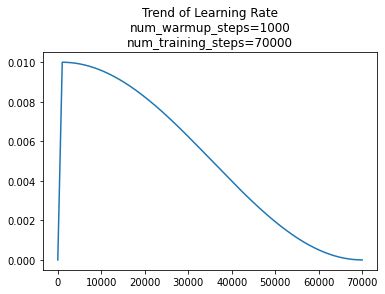

In [37]:
def plot_lr():
    num_warmup_steps=1000
    num_training_steps=70000
    lr = 0.01
    res_list = []
    for current_step in range(70000):
        if current_step < num_warmup_steps:
            res = float(current_step) / float(max(1, num_warmup_steps))
            res_list.append(res * lr)
            continue
        progress = float(current_step - num_warmup_steps) / float(
                    max(1, num_training_steps - num_warmup_steps)
                )
        res = 0.5 * (1.0 + math.cos(math.pi * float(0.5) * 2.0 * progress))
        res_list.append(res * lr)

    plt.plot(res_list)
    plt.title(f'Trend of Learning Rate\nnum_warmup_steps={num_warmup_steps}\nnum_training_steps={num_training_steps}')
    plt.show()

plot_lr()

In [22]:
def get_cosine_schedule_with_warmup(
    opt: Optimizer,
    num_warmup_steps: int,
    num_training_steps: int,
    num_cycles: float = 0.5,
    last_epoch: int = -1
):
    """
    创建一个学习率变化策略,
    学习率跟随cosine值变化,
    在warm up时间段内变化区间在:
        0 -> 优化器设置的学习率 .
    Args:
        opt (Optimizer): 优化器类
        num_warmup_steps (int): 多少步增加一下lr
        num_training_steps (int): 总训练步骤
        num_cycles (float, optional): 变化周期. 默认为 0.5.
        last_epoch (int, optional): _description_. Defaults to -1.
    """
    def lr_lambda(current_step):
        # warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # 衰减
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )
    return LambdaLR(opt, lr_lambda, last_epoch)

#   &#x2728; **训练部分**
这部分和HW01 & HW03基本相同

In [29]:
def trainer(train_loader, valid_loader, model, config, device, rest_net_flag=False):
    # 对于分类任务, 我们常用cross-entropy评估模型表现.
    criterion = nn.CrossEntropyLoss()
    # 初始化优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 
    if config['scheduler_flag']:
        scheduler = get_cosine_schedule_with_warmup(optimizer, config['warmup_steps'], len(train_loader) * config['n_epochs'])
    # 模型存储位置
    save_path =  config['save_path']

    writer = SummaryWriter()
    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    for epoch in range(n_epochs):
        model.train()
        loss_record = []
        train_accs = []
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()             
            x, y = x.to(device), y.to(device)  
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            if config['scheduler_flag']:
                scheduler.step()
            step += 1
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            l_ = loss.detach().item()
            loss_record.append(l_)
            train_accs.append(acc.detach().item())
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': f'{l_:.5f}', 'acc': f'{acc:.5f}'})
        
        
        mean_train_acc = sum(train_accs) / len(train_accs)
        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)
        writer.add_scalar('ACC/train', mean_train_acc, step)
        
        model.eval() # 设置模型为评估模式
        loss_record = []
        test_accs = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()

            loss_record.append(loss.item())
            test_accs.append(acc.detach().item())
            
        mean_valid_acc = sum(test_accs) / len(test_accs)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f},acc: {mean_train_acc:.4f} Valid loss: {mean_valid_loss:.4f},acc: {mean_valid_acc:.4f} ')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)
        writer.add_scalar('ACC/valid', mean_valid_acc, step)
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path) # 保存最优模型
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

# **参数设置**

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 87,
    'dataset_dir': "../input/ml2022spring-hw4/Dataset",
    'n_epochs': 35,      
    'batch_size': 64, 
    
    'scheduler_flag': True,
    'valid_steps': 2000,
    'warmup_steps': 1000,
    # 'total_steps': 70000, # len(train) * n_epochs
    'learning_rate': 1e-3,          
    'early_stop': 300,
    'n_workers': 8,
    'save_path': './models/model.ckpt'
}
print(device)
all_seed(config['seed'])

cuda
Set env random_seed = 87


# **导入数据集**
- 将数据集分割成训练集(90%)和验证集(10%).
- 创建dataloader用于模型训练.
- 用`pad_sequence`方法将一个batch中的数据都扩展成一样的长度(`collate_batch`)  

    Example:
```python
from torch.nn.utils.rnn import pad_sequence
a = torch.ones(25, 40)
b = torch.ones(22, 40)
c = torch.ones(15, 40)
pad_sequence([a, b, c], batch_first=True).size() # 都扩展成一样长
torch.Size([3, 25, 40])
```

In [31]:
def collate_batch(batch):
    # 将一个batch中的数据合并
    """Collate a batch of data."""
    mel, speaker = zip(*batch)
    # 为了保持一个batch内的长度都是一样的所有需要进行padding, 同时设置batch的维度是最前面的一维
    mel = pad_sequence(mel, batch_first=True, padding_value=-20)    # pad log 10^(-20) 一个很小的值
    # mel: (batch size, length, 40)
    return mel, torch.FloatTensor(speaker).long()


data_dir = config['dataset_dir']
dataset = myDataset(data_dir)
speaker_num = dataset.get_speaker_number()
speaker2id = dataset.speaker2id
# 将数据拆分成训练集和验证集
trainlen = int(0.9 * len(dataset))
lengths = [trainlen, len(dataset) - trainlen]
trainset, validset = random_split(dataset, lengths)
testset = InferenceDataset(data_dir)

train_loader = DataLoader(
    trainset,
    batch_size=config['batch_size'],
    shuffle=True,
    drop_last=True,
    num_workers=config['n_workers'],
    pin_memory=True,
    collate_fn=collate_batch,
)

valid_loader = DataLoader(
    validset,
    batch_size=config['batch_size'],
    num_workers=config['n_workers'],
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_batch,
)


test_loader = DataLoader(
    testset,
    batch_size=1,
    num_workers=config['n_workers'],
    shuffle=False,
    drop_last=False,
    pin_memory=True,
    collate_fn=inference_collate_batch,
)

#  &#x1F4CC; **开始训练！**

In [32]:
model = Classifier(
    input_dim=40,  # n_mel
    d_model=80,
    n_spks=600, 
    dropout=0.1
).to(device)
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/35]: 100%|██████████| 796/796 [00:56<00:00, 14.21it/s, loss=4.99485, acc=0.09375]


Epoch [1/35]: Train loss: 5.9355,acc: 0.0156 Valid loss: 4.9507,acc: 0.0595 
Saving model with loss 4.951...


Epoch [2/35]: 100%|██████████| 796/796 [00:27<00:00, 29.22it/s, loss=3.60158, acc=0.21875]


Epoch [2/35]: Train loss: 4.4725,acc: 0.1081 Valid loss: 3.9621,acc: 0.1795 
Saving model with loss 3.962...


Epoch [3/35]: 100%|██████████| 796/796 [00:28<00:00, 28.36it/s, loss=3.16526, acc=0.28125]


Epoch [3/35]: Train loss: 3.7922,acc: 0.1974 Valid loss: 3.4876,acc: 0.2493 
Saving model with loss 3.488...


Epoch [4/35]: 100%|██████████| 796/796 [00:28<00:00, 27.79it/s, loss=3.33363, acc=0.29688]


Epoch [4/35]: Train loss: 3.4181,acc: 0.2598 Valid loss: 3.2367,acc: 0.2926 
Saving model with loss 3.237...


Epoch [5/35]: 100%|██████████| 796/796 [00:28<00:00, 28.13it/s, loss=3.20587, acc=0.31250]


Epoch [5/35]: Train loss: 3.1651,acc: 0.3075 Valid loss: 3.0073,acc: 0.3425 
Saving model with loss 3.007...


Epoch [6/35]: 100%|██████████| 796/796 [00:29<00:00, 26.65it/s, loss=2.82753, acc=0.28125]


Epoch [6/35]: Train loss: 2.9686,acc: 0.3386 Valid loss: 2.8559,acc: 0.3695 
Saving model with loss 2.856...


Epoch [7/35]: 100%|██████████| 796/796 [00:30<00:00, 26.47it/s, loss=3.00548, acc=0.32812]


Epoch [7/35]: Train loss: 2.8109,acc: 0.3689 Valid loss: 2.6610,acc: 0.4125 
Saving model with loss 2.661...


Epoch [8/35]: 100%|██████████| 796/796 [00:29<00:00, 26.75it/s, loss=2.59602, acc=0.40625]


Epoch [8/35]: Train loss: 2.6778,acc: 0.3940 Valid loss: 2.6267,acc: 0.4190 
Saving model with loss 2.627...


Epoch [9/35]: 100%|██████████| 796/796 [00:29<00:00, 27.35it/s, loss=2.58245, acc=0.37500]


Epoch [9/35]: Train loss: 2.5649,acc: 0.4128 Valid loss: 2.4476,acc: 0.4528 
Saving model with loss 2.448...


Epoch [10/35]: 100%|██████████| 796/796 [00:28<00:00, 28.17it/s, loss=2.12685, acc=0.45312]


Epoch [10/35]: Train loss: 2.4754,acc: 0.4308 Valid loss: 2.3831,acc: 0.4732 
Saving model with loss 2.383...


Epoch [11/35]: 100%|██████████| 796/796 [00:27<00:00, 28.53it/s, loss=2.19862, acc=0.53125]


Epoch [11/35]: Train loss: 2.3947,acc: 0.4504 Valid loss: 2.2878,acc: 0.4892 
Saving model with loss 2.288...


Epoch [12/35]: 100%|██████████| 796/796 [00:28<00:00, 28.19it/s, loss=2.14563, acc=0.46875]


Epoch [12/35]: Train loss: 2.3208,acc: 0.4597 Valid loss: 2.3081,acc: 0.4828 


Epoch [13/35]: 100%|██████████| 796/796 [00:28<00:00, 27.87it/s, loss=2.26823, acc=0.39062]


Epoch [13/35]: Train loss: 2.2543,acc: 0.4759 Valid loss: 2.1940,acc: 0.5163 
Saving model with loss 2.194...


Epoch [14/35]: 100%|██████████| 796/796 [00:28<00:00, 28.27it/s, loss=2.28814, acc=0.45312]


Epoch [14/35]: Train loss: 2.1906,acc: 0.4887 Valid loss: 2.1073,acc: 0.5268 
Saving model with loss 2.107...


Epoch [15/35]: 100%|██████████| 796/796 [00:27<00:00, 28.64it/s, loss=2.36237, acc=0.48438]


Epoch [15/35]: Train loss: 2.1317,acc: 0.5014 Valid loss: 2.0983,acc: 0.5256 
Saving model with loss 2.098...


Epoch [16/35]: 100%|██████████| 796/796 [00:27<00:00, 28.74it/s, loss=1.77035, acc=0.57812]


Epoch [16/35]: Train loss: 2.0813,acc: 0.5101 Valid loss: 2.0207,acc: 0.5478 
Saving model with loss 2.021...


Epoch [17/35]: 100%|██████████| 796/796 [00:27<00:00, 28.58it/s, loss=2.45166, acc=0.56250]


Epoch [17/35]: Train loss: 2.0341,acc: 0.5211 Valid loss: 2.0007,acc: 0.5471 
Saving model with loss 2.001...


Epoch [18/35]: 100%|██████████| 796/796 [00:28<00:00, 27.98it/s, loss=2.22434, acc=0.48438]


Epoch [18/35]: Train loss: 2.0002,acc: 0.5276 Valid loss: 1.9689,acc: 0.5518 
Saving model with loss 1.969...


Epoch [19/35]: 100%|██████████| 796/796 [00:28<00:00, 28.41it/s, loss=2.04935, acc=0.46875]


Epoch [19/35]: Train loss: 1.9536,acc: 0.5394 Valid loss: 1.9298,acc: 0.5655 
Saving model with loss 1.930...


Epoch [20/35]: 100%|██████████| 796/796 [00:27<00:00, 28.48it/s, loss=1.83221, acc=0.56250]


Epoch [20/35]: Train loss: 1.9053,acc: 0.5431 Valid loss: 1.8723,acc: 0.5705 
Saving model with loss 1.872...


Epoch [21/35]: 100%|██████████| 796/796 [00:27<00:00, 28.91it/s, loss=1.97107, acc=0.57812]


Epoch [21/35]: Train loss: 1.8743,acc: 0.5534 Valid loss: 1.8888,acc: 0.5716 


Epoch [22/35]: 100%|██████████| 796/796 [00:27<00:00, 28.66it/s, loss=1.53612, acc=0.67188]


Epoch [22/35]: Train loss: 1.8438,acc: 0.5607 Valid loss: 1.8568,acc: 0.5856 
Saving model with loss 1.857...


Epoch [23/35]: 100%|██████████| 796/796 [00:27<00:00, 28.50it/s, loss=1.65329, acc=0.60938]


Epoch [23/35]: Train loss: 1.8093,acc: 0.5662 Valid loss: 1.8053,acc: 0.5939 
Saving model with loss 1.805...


Epoch [24/35]: 100%|██████████| 796/796 [00:28<00:00, 28.29it/s, loss=1.99409, acc=0.48438]


Epoch [24/35]: Train loss: 1.7781,acc: 0.5748 Valid loss: 1.7939,acc: 0.5943 
Saving model with loss 1.794...


Epoch [25/35]: 100%|██████████| 796/796 [00:27<00:00, 28.71it/s, loss=1.45089, acc=0.67188]


Epoch [25/35]: Train loss: 1.7634,acc: 0.5774 Valid loss: 1.7809,acc: 0.6044 
Saving model with loss 1.781...


Epoch [26/35]: 100%|██████████| 796/796 [00:27<00:00, 28.74it/s, loss=1.96837, acc=0.56250]


Epoch [26/35]: Train loss: 1.7360,acc: 0.5804 Valid loss: 1.7456,acc: 0.6010 
Saving model with loss 1.746...


Epoch [27/35]: 100%|██████████| 796/796 [00:28<00:00, 28.40it/s, loss=1.41114, acc=0.71875]


Epoch [27/35]: Train loss: 1.7184,acc: 0.5856 Valid loss: 1.7315,acc: 0.6083 
Saving model with loss 1.731...


Epoch [28/35]: 100%|██████████| 796/796 [00:28<00:00, 28.40it/s, loss=2.00252, acc=0.50000]


Epoch [28/35]: Train loss: 1.6994,acc: 0.5923 Valid loss: 1.7210,acc: 0.6106 
Saving model with loss 1.721...


Epoch [29/35]: 100%|██████████| 796/796 [00:28<00:00, 28.17it/s, loss=2.06908, acc=0.45312]


Epoch [29/35]: Train loss: 1.6816,acc: 0.5956 Valid loss: 1.7263,acc: 0.6069 


Epoch [30/35]: 100%|██████████| 796/796 [00:27<00:00, 29.30it/s, loss=1.20732, acc=0.67188]


Epoch [30/35]: Train loss: 1.6613,acc: 0.5998 Valid loss: 1.6684,acc: 0.6072 
Saving model with loss 1.668...


Epoch [31/35]: 100%|██████████| 796/796 [00:27<00:00, 29.45it/s, loss=1.84132, acc=0.59375]


Epoch [31/35]: Train loss: 1.6512,acc: 0.6004 Valid loss: 1.6914,acc: 0.6199 


Epoch [32/35]: 100%|██████████| 796/796 [00:27<00:00, 29.24it/s, loss=1.58765, acc=0.62500]


Epoch [32/35]: Train loss: 1.6466,acc: 0.6020 Valid loss: 1.7334,acc: 0.6051 


Epoch [33/35]: 100%|██████████| 796/796 [00:27<00:00, 28.56it/s, loss=1.75043, acc=0.62500]


Epoch [33/35]: Train loss: 1.6376,acc: 0.6050 Valid loss: 1.7110,acc: 0.6175 


Epoch [34/35]: 100%|██████████| 796/796 [00:27<00:00, 29.09it/s, loss=1.57912, acc=0.65625]


Epoch [34/35]: Train loss: 1.6399,acc: 0.6036 Valid loss: 1.6946,acc: 0.6211 


Epoch [35/35]: 100%|██████████| 796/796 [00:27<00:00, 28.73it/s, loss=1.64054, acc=0.62500]


Epoch [35/35]: Train loss: 1.6312,acc: 0.6090 Valid loss: 1.7201,acc: 0.6143 


# **测试并生成预测结果的csv**

In [33]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(config['save_path']))
model_best.eval()
mapping_path = Path(data_dir) / "mapping.json"
mapping = json.load(mapping_path.open())
pred_id = []
pred_final_cls = []
with torch.no_grad():
    for name, data in tqdm(test_loader):
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        pred_id += name
        pred_final_cls += [mapping["id2speaker"][str(test_label[0])]]

100%|██████████| 8000/8000 [00:24<00:00, 321.50it/s]


In [34]:
df = pd.DataFrame()
df["Id"] = pred_id
df["Category"] = pred_final_cls
df.to_csv("submission.csv",index = False)

# 贡献者

孙成超
- Github: https://github.com/scchy
- Email: hyscc1994@foxmail.com